In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

Bad value in file '/Users/yossy/.matplotlib/matplotlibrc', line 1 ('backend : Qt4Agg'): Key backend: 'qt4agg' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [56]:
# Convolution

class ConvSoftmax1d(nn.Module):
    def __init__(self, kernel):
        super(ConvSoftmax1d, self).__init__()
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]
        pad = int(np.floor(ks / 2))
        self.conv1 = nn.Conv1d(in_channels=1,
                               out_channels=1,
                               kernel_size=ks,
                               stride=1,
                               padding=pad,
                               padding_mode="replicate",
                               bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.act(self.conv1(x))
        return x
    

class ConvSoftmax2d(nn.Module):
    def __init__(self, kernel):
        super(ConvSoftmax2d, self).__init__()
        
        assert kernel.shape[0] == kernel.shape[1], "model needs a square kernel"
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]
        pad = int(np.floor(ks / 2))
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=1,
                               kernel_size=ks,
                               stride=1,
                               padding=pad,
                               padding_mode="replicate",
                               bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        n, c, xs, ys = x.shape
        
        x = self.conv1(x)
        
        x = x.view(-1, c*xs*ys)
        maxes = torch.max(x, 1, keepdim=True)[0]
        x_exp = torch.exp(x-maxes)
        x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
        x = x_exp/x_exp_sum
        
        x = x.view(-1, c, xs, ys)
        return x

    
# Deconvolution

class DeconvSoftmax1d(nn.Module):
    def __init__(self, kernel):
        super(DeconvSoftmax1d, self).__init__()
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]

        self.conv1 = nn.ConvTranspose1d(
            in_channels=1,
            out_channels=1,
            kernel_size=ks,
            stride=1,
            padding=0,
            output_padding=0,
            bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.act(self.conv1(x))
        return x
    

class DeconvSoftmax2d(nn.Module):
    def __init__(self, kernel):
        super(DeconvSoftmax2d, self).__init__()
        
        assert kernel.shape[0] == kernel.shape[1], "model needs a square kernel"
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]
        pad = int(np.floor(ks / 2))


        self.conv1 = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=ks,
            stride=1,
            padding=pad,
            output_padding=0,
            bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        n, c, xs, ys = x.shape
        
        x = self.conv1(x)
        
        x = x.view(-1, c*xs*ys)
        maxes = torch.max(x, 1, keepdim=True)[0]
        x_exp = torch.exp(x-maxes)
        x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
        x = x_exp/x_exp_sum
        
        x = x.view(-1, c, xs, ys)
        return x

# testing 1D Convolution Softmax 

n:  1
18
n:  2
10
13
n:  3
4
16
7
torch.Size([3, 1, 20])


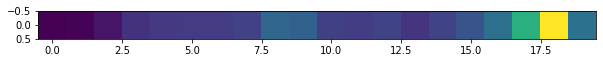

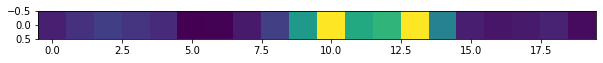

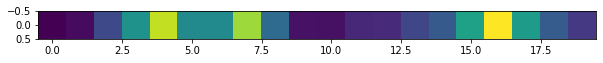

In [12]:
cs1d = ConvSoftmax1d(kernel=np.array([0.1, 0.5, 1, 0.5, 0.1], dtype=np.float32))

n = 3
l = 20
x = 0.1 * torch.randn(n*l).reshape(n, 1, l)

for i in range(n):
    m = i + 1
    print("n: ", m)
    for j in range(m):
        ix = np.random.randint(l)
        x[i, 0, ix] = 1
        print(ix)

y = cs1d(x)
print(y.shape)


for i in range(n):
    plt.figure(figsize=(10, 5))
    y_ = y.detach().numpy()[i, 0]
    plt.imshow([y_])
    plt.show()

# testing 2D Convolution Softmax

torch.Size([3, 1, 10, 10])
torch.Size([3, 1, 10, 10])


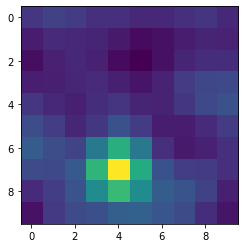

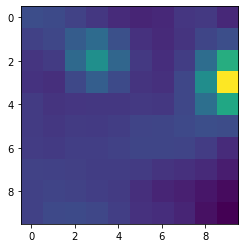

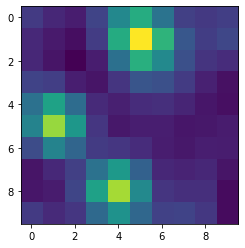

In [17]:
def gkern(l=5, sig=0.1):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return (kernel / np.sum(kernel)).astype(np.float32)

kernel = gkern(l=5, sig=1.0)

cs2d = ConvSoftmax2d(kernel=kernel)

n = 3
l = 10
x = 0.1 * torch.randn(n*l*l).reshape(n, 1, l, l)

print(x.shape)

for i in range(n):
    m = i + 1
    for j in range(m):
        ix, iy = np.random.randint(0, l, 2)
        x[i, 0, ix, iy] = 2

y = cs2d(x)

print(y.shape)

for i in range(n):
    y_ = y.detach().numpy()[i, 0]
    plt.imshow(y_)#, vmin=0, vmax=1)
    plt.show()

# Deconvolution Softmax

n:  1
8
n:  2
8
17
n:  3
11
3
15
torch.Size([3, 1, 24])


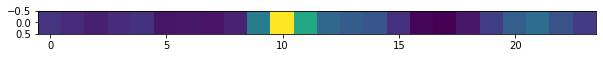

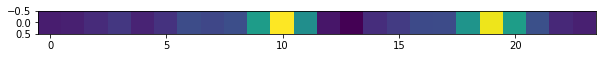

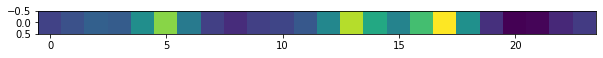

In [70]:
kernel = np.array([0.1, 0.5, 1, 0.5, 0.1], dtype=np.float32)
#kernel = np.random.rand(5).astype(np.float32)

ds1d = DeconvSoftmax1d(kernel=kernel)

n = 3
l = 20
x = 0.1 * torch.randn(n*l).reshape(n, 1, l)

for i in range(n):
    m = i + 1
    print("n: ", m)
    for j in range(m):
        ix = np.random.randint(l)
        x[i, 0, ix] = 1
        print(ix)

y = ds1d(x)
print(y.shape)


for i in range(n):
    plt.figure(figsize=(10, 5))
    y_ = y.detach().numpy()[i, 0]
    plt.imshow([y_])
    plt.show()

torch.Size([3, 1, 10, 10])
torch.Size([3, 1, 10, 10])


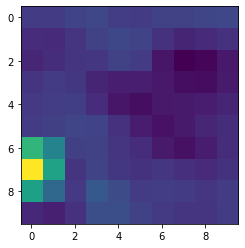

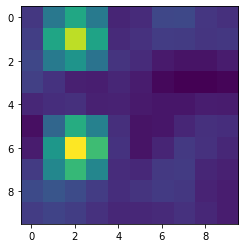

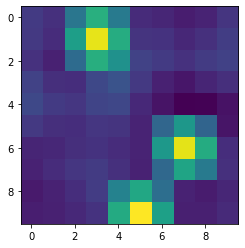

In [67]:
kernel = gkern(l=3, sig=1.0)
#kernel = np.random.rand(5, 5).astype(np.float32)

ds2d = DeconvSoftmax2d(kernel=kernel)

n = 3
l = 10
x = 0.1 * torch.randn(n*l*l).reshape(n, 1, l, l)

print(x.shape)

for i in range(n):
    m = i + 1
    for j in range(m):
        ix, iy = np.random.randint(0, l, 2)
        x[i, 0, ix, iy] = 2

y = ds2d(x)

print(y.shape)

for i in range(n):
    y_ = y.detach().numpy()[i, 0]
    plt.imshow(y_)#, vmin=0, vmax=1)
    plt.show()